In [ ]:
import torch
from torch import nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel
from sklearn.preprocessing import OneHotEncoder
import tqdm
import torch.optim as optim
import numpy as np
from sklearn.utils import shuffle


data = pd.read_csv("protein_data.tsv.gz", sep="\t")
data = data[data["Length"] <= 256] # removes all proteins with a length > 256
# Reduce EC number to 3 digits to decrease data size
data = data.dropna(subset=['EC number']).assign(
    ec_number_reduced = lambda x: x['EC number'].str.split(".").str[:3].str.join(".")
)

# Filter out EC numbers with frequency less than 100
ec_number_counts = data["ec_number_reduced"].value_counts()
data = data[data["ec_number_reduced"].isin(ec_number_counts[ec_number_counts >= 100].index)]

<ipython-input-1-bf91582fe2ca>:13: DtypeWarning: Columns (12,15,16,18,19,21,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("protein_data.tsv.gz", sep="\t")


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

encoder = OneHotEncoder(sparse=False)
encoded_column = encoder.fit_transform(data[["ec_number_reduced"]])

data, encoded_column = shuffle(data, encoded_column, random_state=42)

# Split data into 80% training data and 20% validation data
train_size = int(0.8 * len(data))
train_data = data[:train_size]
val_data = data[train_size:]

train_labels = encoded_column[:train_size]
val_labels = encoded_column[train_size:]

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
train_dataset = CustomDataset(train_data["Sequence"].tolist(), train_labels)
val_dataset = CustomDataset(val_data["Sequence"].tolist(), val_labels)

# Used to combine data into batches
def collate_fn(batch):
    proteins = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    return tokenizer(proteins, padding=True), torch.tensor(labels)

batch_size = 64
# Put data into batches
train_dataloader = DataLoader(train_dataset, batch_size, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size, collate_fn=collate_fn, shuffle=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
avg_seq_len = 0
for i in range(len(data)):
    avg_seq_len += len(data.iloc[i]["Sequence"])
avg_seq_len /= len(data)

print(avg_seq_len)

188.54615593433442


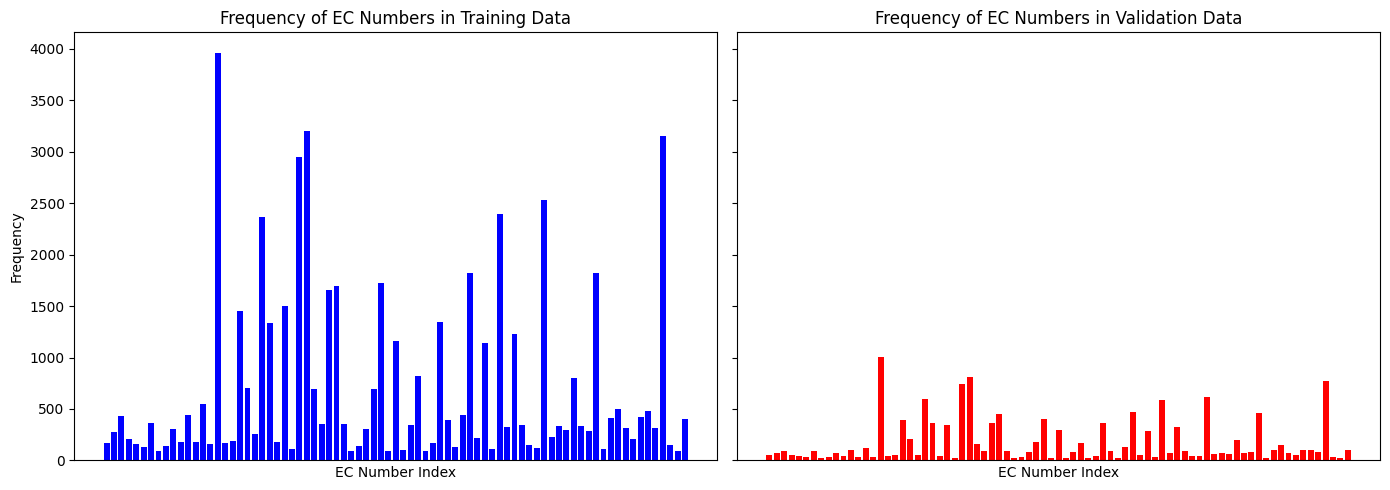

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

categories = encoder.categories_[0]

ec_to_index = {category : index for index, category in enumerate(categories)}
index_to_ec = {index : category for index, category in enumerate(categories)}

train_indices = train_data["ec_number_reduced"].map(ec_to_index)
val_indices = val_data["ec_number_reduced"].map(ec_to_index)

train_freq = Counter(train_indices)
val_freq = Counter(val_indices)

train_freq_sorted = [train_freq[i] for i in range(len(ec_to_index))]
val_freq_sorted = [val_freq[i] for i in range(len(ec_to_index))]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)

axes[0].bar(range(len(ec_to_index)), train_freq_sorted, color="b")
axes[0].set_title("Frequency of EC Numbers in Training Data")
axes[0].set_xlabel("EC Number Index")
axes[0].set_ylabel("Frequency")
axes[0].set_xticks([])

axes[1].bar(range(len(ec_to_index)), val_freq_sorted, color="r")
axes[1].set_title("Frequency of EC Numbers in Validation Data")
axes[1].set_xlabel("EC Number Index")
axes[1].set_xticks([])

plt.tight_layout()
plt.show()

In [ ]:
class MyModel(nn.Module):
    def __init__(self, esm_model, num_classes):
        super(MyModel, self).__init__()
        self.esm_model = esm_model
        for param in self.esm_model.parameters():
            param.requires_grad = False
        # Four layers: 320, 200, 128, num_classes
        self.fc_layers = nn.Sequential(nn.Linear(320, 200),
                                       nn.ReLU(),
                                       nn.Linear(200, 128),
                                       nn.ReLU(),
                                       nn.Linear(128, num_classes))

    def forward(self, input_ids, attention_mask):
        outputs = self.esm_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        pool = torch.mean(outputs.hidden_states[-1], dim=1)
        logits = self.fc_layers(pool)
        probs = torch.softmax(logits, dim=1)
        return logits, probs

num_classes = len(set(data["ec_number_reduced"].tolist()))
esm_model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = MyModel(esm_model, num_classes).to("cuda")

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Assign weight to each EC number

custom_weights = [0 for i in range(num_classes)]

for ec in data["ec_number_reduced"]:
    index = ec_to_index[ec]
    custom_weights[index] += 1

custom_weights = torch.tensor(custom_weights, dtype=torch.float32)
custom_weights = custom_weights.min() / custom_weights
weight_tensor = custom_weights.to('cuda')

loss_function = nn.CrossEntropyLoss(weight=weight_tensor)

learning_rate = 0.001
epochs = 1000
early_stop_count = 5
min_loss_improvement = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []
accuracies = []
top_5_accuracies = []

best_train_loss = float("inf")
no_improvement_count = 0

# Load model from checkpoint
current_epoch = 0
#checkpoint = torch.load(f'/content/drive/My Drive/Protein Function ESM/checkpoint_epoch_{current_epoch}.pth')
#model.load_state_dict(checkpoint['state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer'])

train_vs_val_loss = []
for epoch in range(current_epoch, epochs):
    model.train()

    train_loss = 0
    for batch in tqdm.tqdm(train_dataloader):
        inputs = torch.tensor(batch[0]["input_ids"]).to("cuda")
        attention_masks = torch.tensor(batch[0]["attention_mask"]).to("cuda")
        labels = batch[1].to("cuda")

        optimizer.zero_grad()
        logits, probs = model(inputs, attention_masks)
        loss = loss_function(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    losses.append(train_loss)

    # Accuracy
    model.eval()

    correct = 0
    total = 0
    top_5_correct = 0
    top_5_total = 0
    val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            inputs = torch.tensor(batch[0]["input_ids"]).to("cuda")
            attention_masks = torch.tensor(batch[0]["attention_mask"]).to("cuda")
            labels = batch[1].to("cuda")

            # Top-1 Accuracy
            logits, probs = model(inputs, attention_masks)
            pred_class = probs.argmax(-1).flatten()
            labels = labels.argmax(-1).flatten()
            correct += (pred_class == labels).sum().item()
            total += pred_class.shape[0]

            # Top-5 Accuracy
            pred_classes = probs.topk(5, dim=1)[1]

            for i in range(pred_classes.shape[0]):
                if labels[i] in pred_classes[i]:
                    top_5_correct += 1
                top_5_total += 1

            val_loss += loss_function(logits, labels).item()
        val_loss /= len(val_dataloader)

    train_vs_val_loss.append((train_loss, val_loss))

    accuracy = correct / total * 100
    top_5_accuracy = top_5_correct / top_5_total * 100
    accuracies.append(accuracy)
    top_5_accuracies.append(accuracy)
    print(f"Epoch {epoch}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, accuracy: {accuracy}")

    # Early stop
    if best_train_loss - train_loss > min_loss_improvement:
        best_train_loss = train_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stop_count:
        break

    if epoch > 50:
        checkpoint = {
            "epoch": epoch + 1,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "loss": loss.item()
        }

        torch.save(checkpoint, f"/content/drive/My Drive/Protein Function ESM/checkpoint_epoch_{epoch+1}.pth")

  0%|          | 0/875 [00:00<?, ?it/s]<ipython-input-2-ff98d5a4a211>:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return tokenizer(proteins, padding=True), torch.tensor(labels)
  0%|          | 0/875 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
checkpoint = {
            "epoch": epoch + 1,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "loss": loss.item()
        }

torch.save(checkpoint, f"/content/drive/My Drive/Protein Function ESM/model_epoch_40.pth")

NameError: name 'loss' is not defined

In [ ]:
checkpoint_path = "/content/drive/My Drive/Protein Function ESM/model_epoch_40.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
model.eval()

correct = 0
total = 0

top_5_correct = 0
top_5_total = 0

class_correct = [0] * num_classes
class_total = [0] * num_classes

class_false_positives = [0] * num_classes
class_false_negatives = [0] * num_classes

with torch.no_grad():
    for batch in tqdm.tqdm(val_dataloader):
        inputs = torch.tensor(batch[0]["input_ids"]).to("cuda")
        attention_masks = torch.tensor(batch[0]["attention_mask"]).to("cuda")
        labels = batch[1].to("cuda")

        # Top-1 Accuracy
        logits, probs = model(inputs, attention_masks)
        pred_class = probs.argmax(-1).flatten()
        labels = labels.argmax(-1).flatten()
        correct += (pred_class == labels).sum().item()
        total += pred_class.shape[0]

        # Top-5 Accuracy
        pred_classes = probs.topk(60, dim=1)[1]

        for i in range(pred_classes.shape[0]):
            if labels[i] in pred_classes[i]:
                top_5_correct += 1
            top_5_total += 1

        # Accuracy per class
        for i in range(labels.shape[0]):
            if pred_class[i] == labels[i]:
                class_correct[labels[i]] += 1
            else:
                class_false_positives[pred_class[i]] += 1 # Prediction was wrong
                class_false_negatives[labels[i]] += 1 # Label was not predicted
            class_total[labels[i]] += 1

  0%|          | 0/219 [00:00<?, ?it/s]<ipython-input-2-ff98d5a4a211>:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return tokenizer(proteins, padding=True), torch.tensor(labels)
100%|██████████| 219/219 [01:02<00:00,  3.50it/s]


In [ ]:
accuracy = correct / total * 100
top_5_accuracy = top_5_correct / top_5_total * 100
print(f"Accuracy: {accuracy:.4f}")
print(f"Top-5 Accuracy: {top_5_accuracy:.4f}")

highest = 0
highest_idx = 0
for i in range(num_classes):
    if class_total[i] != 0:
        if class_correct[i] / class_total[i] > highest:
            highest = class_correct[i] / class_total[i]
            highest_idx = i

lowest = float("inf")
lowest_idx = 0
for i in range(num_classes):
    if class_total[i] != 0:
        if class_correct[i] / class_total[i] < lowest:
            lowest = class_correct[i] / class_total[i]
            lowest_idx = i

highest_accuracy = highest * 100
lowest_accuracy = lowest * 100
print(f"Highest Accuracy Label: {highest_idx}, Accuracy: {highest_accuracy:.4f}%")
print(f"Lowest Accuracy Label: {lowest_idx}, Accuracy: {lowest_accuracy:.4f}%")

Accuracy: 94.5925
Top-5 Accuracy: 99.9500
Highest Accuracy Label: 4, Accuracy: 100.0000%
Lowest Accuracy Label: 47, Accuracy: 60.0000%


In [ ]:
from collections import Counter

true_labels = []
for batch in val_dataloader:
    labels = batch[1].to("cuda")
    true_labels.extend(labels.argmax(-1).flatten().tolist())

class_counts = Counter(true_labels)
most_common_class, most_common_class_count = class_counts.most_common(1)[0]

baseline_accuracy = most_common_class_count / len(true_labels) * 100

print(f"Baseline Accuracy (most frequent class): {baseline_accuracy:.4f}%")

Baseline Accuracy (most frequent class): 7.1791%


In [ ]:
for i in range(num_classes):
    print(class_correct[i], class_total[i], class_false_positives[i], class_false_negatives[i])

35 57 21 22
62 77 24 15
84 92 16 8
52 54 6 2
42 42 1 0
31 33 2 2
85 88 7 3
27 28 1 1
35 36 0 1
71 73 8 2
36 44 6 8
101 103 2 2
36 38 4 2
116 120 3 4
34 35 1 1
956 1005 18 49
42 44 0 2
55 56 0 1
348 390 5 42
203 210 39 7
53 57 5 4
588 600 17 12
336 359 35 23
40 40 1 0
318 347 11 29
24 24 0 0
730 738 15 8
780 811 10 31
151 161 5 10
88 91 2 3
329 366 54 37
414 447 30 33
86 88 1 2
21 24 2 3
28 29 0 1
82 83 3 1
161 175 11 14
394 402 41 8
21 27 7 6
267 295 16 28
19 23 5 4
58 78 14 20
160 174 12 14
22 27 3 5
36 40 6 4
344 359 5 15
92 96 5 4
12 20 11 8
129 130 1 1
443 472 15 29
48 49 1 1
277 285 34 8
30 36 2 6
559 590 27 31
70 72 5 2
314 329 15 15
81 92 4 11
38 40 7 2
40 41 3 1
577 614 28 37
65 67 6 2
71 72 17 1
58 60 9 2
181 202 7 21
71 76 3 5
71 85 13 14
447 464 8 17
20 22 2 2
105 106 2 1
136 147 6 11
71 72 4 1
52 53 0 1
101 102 0 1
100 102 11 2
75 78 10 3
757 774 18 17
31 37 1 6
26 27 2 1
95 97 3 2


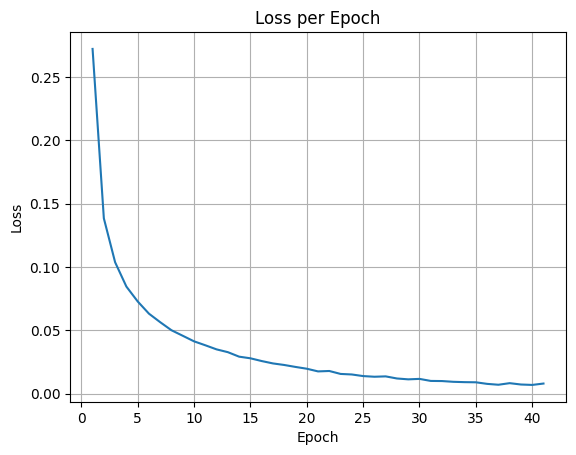

In [ ]:
epochs_lst = list(range(1, len(losses)+1))

plt.plot(epochs_lst, losses)
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

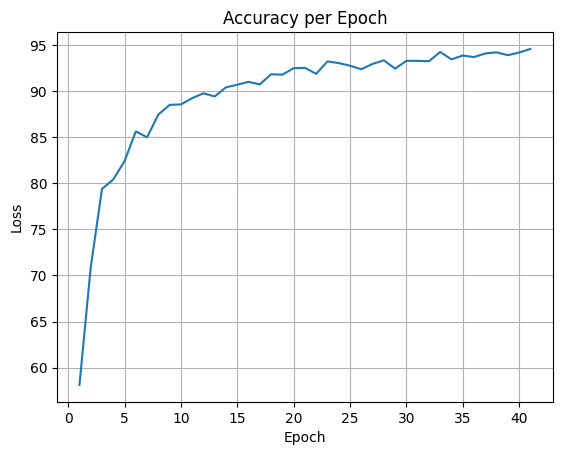

In [ ]:
plt.plot(epochs_lst, accuracies)
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

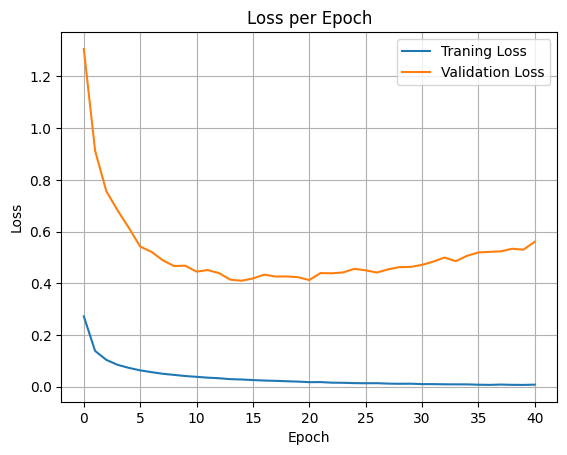

In [ ]:
val_losses = [x[1] for x in train_vs_val_loss]

plt.plot(losses, label="Traning Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print(data["ec_number_reduced"].iloc[highest_idx])
print(data["ec_number_reduced"].iloc[lowest_idx])
print(class_total[highest_idx], class_total[lowest_idx])
print()
for i in range(num_classes):
    if class_correct[i] == 0 and class_total[i] != 0:
        print(data["ec_number_reduced"].iloc[i], class_total[i])

7.1.1
2.4.2
42 20



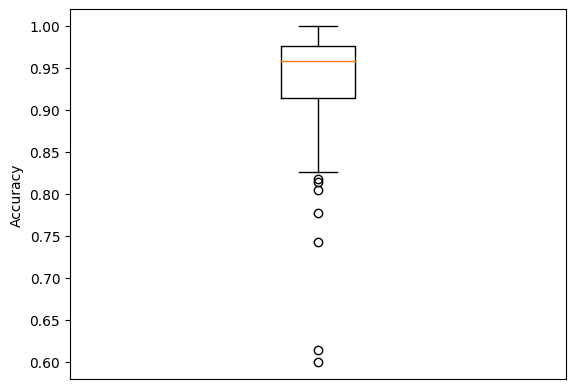

0.9583333333333334
0.9147349956145846 0.9764412416851441 0.06170624607055952
[(0.6140350877192983, 0, '1.-.-'), (0.8051948051948052, 1, '1.1.1'), (0.8181818181818182, 10, '1.5.1'), (0.7777777777777778, 38, '3.1.27'), (0.7435897435897436, 41, '3.2.1'), (0.8148148148148148, 43, '3.4.-'), (0.6, 47, '3.4.24')]


In [ ]:
class_accuracies = []
for i in range(num_classes):
    if class_total[i] > 0:
        accuracy = class_correct[i] / class_total[i]
        class_accuracies.append((accuracy, i))

#class_accuracies.sort()

accuracies_only = [acc[0] for acc in class_accuracies]
plt.boxplot(accuracies_only)
plt.xticks([])
plt.ylabel("Accuracy")
plt.show()

Q1 = np.percentile(accuracies_only, 25)
median = np.percentile(accuracies_only, 50)
Q3 = np.percentile(accuracies_only, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = [(acc[0], acc[1], index_to_ec[acc[1]]) for acc in class_accuracies if acc[0] < lower_bound or acc[0] > upper_bound]

print(median)
print(Q1, Q3, IQR)
print(outliers)

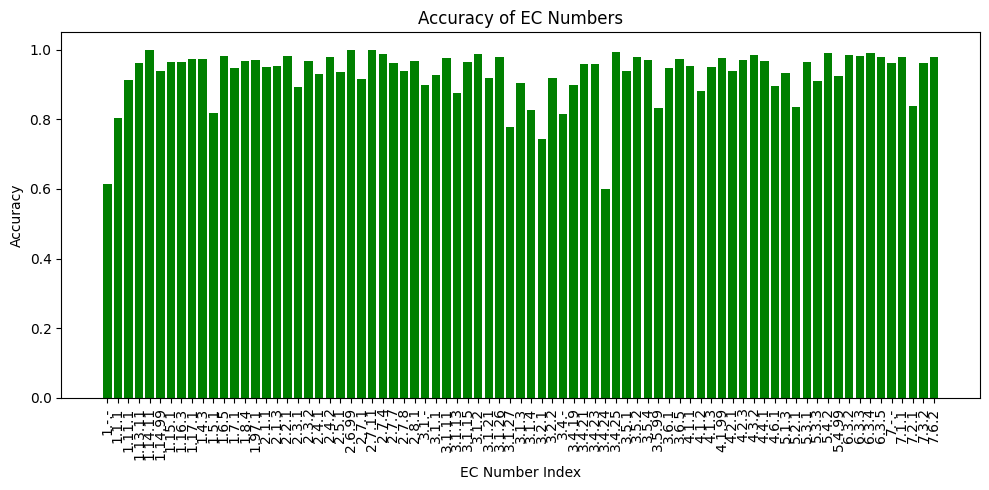

In [ ]:
accuracies = [(i, class_correct[i] / class_total[i]) for i in range(num_classes) if class_total[i] > 0]
ec = [index_to_ec[acc[0]] for acc in accuracies]
lst = [acc[1] for acc in accuracies]

plt.figure(figsize=(10, 5))
plt.bar(range(len(lst)), lst, color='green')
plt.title("Accuracy of EC Numbers")
plt.xlabel("EC Number Index")
plt.ylabel("Accuracy")
plt.xticks(range(len(ec)), ec, rotation='vertical')
plt.tight_layout()
plt.show()

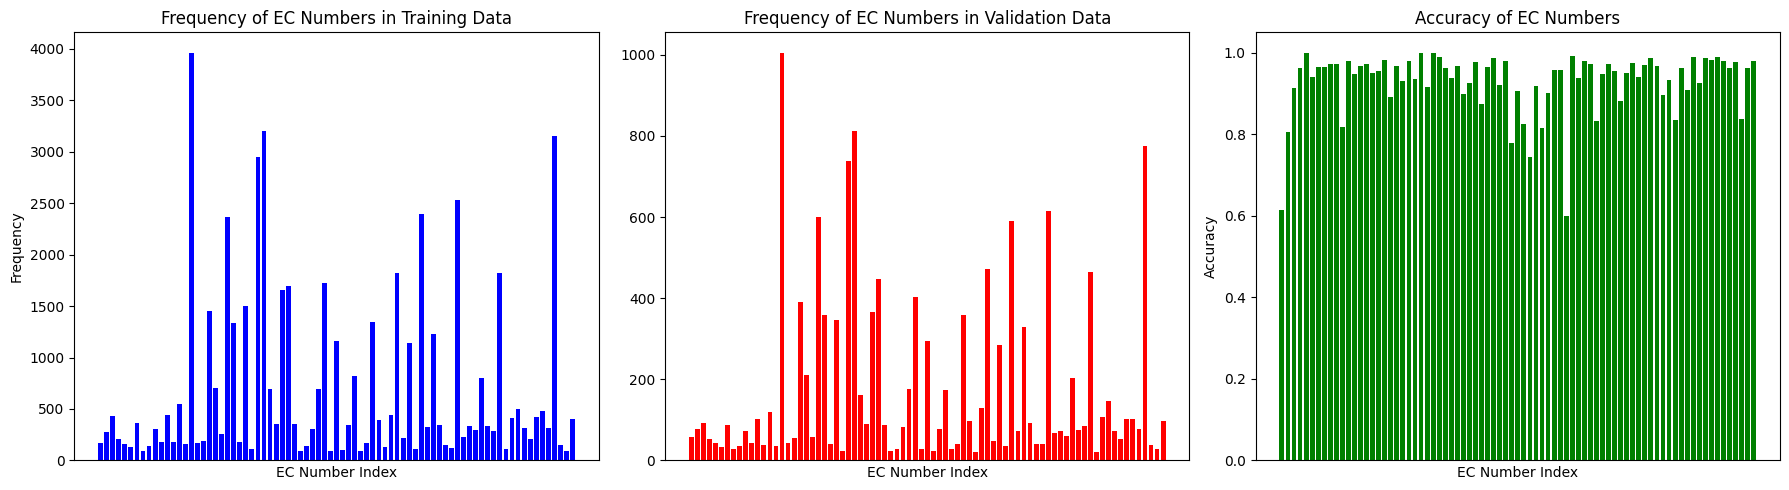

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot for training data frequencies
axes[0].bar(range(len(ec_to_index)), train_freq_sorted, color="b")
axes[0].set_title("Frequency of EC Numbers in Training Data")
axes[0].set_xlabel("EC Number Index")
axes[0].set_ylabel("Frequency")
axes[0].set_xticks([])

# Plot for validation data frequencies
axes[1].bar(range(len(ec_to_index)), val_freq_sorted, color="r")
axes[1].set_title("Frequency of EC Numbers in Validation Data")
axes[1].set_xlabel("EC Number Index")
axes[1].set_xticks([])

# Plot for accuracy of EC numbers
axes[2].bar(range(len(lst)), lst, color='green')
axes[2].set_title("Accuracy of EC Numbers")
axes[2].set_xlabel("EC Number Index")
axes[2].set_ylabel("Accuracy")
axes[2].set_xticks(range(len(ec)))
axes[2].set_xticks([])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
outlier_details = []
for acc, idx, ec_number in outliers:
    train_occurrences = train_freq.get(ec_to_index[ec_number], 0)
    val_occurrences = val_freq.get(ec_to_index[ec_number], 0)
    total_occurrences = train_occurrences + val_occurrences
    outlier_details.append((ec_number, acc, train_occurrences, val_occurrences, total_occurrences))

for detail in outlier_details:
    print(f"EC Number: {detail[0]}, Accuracy: {detail[1]:.2f}, Train Freq: {detail[2]}, Validation Freq: {detail[3]}, Total Freq: {detail[4]}")
    #print(ec_to_index[detail[0]], custom_weights[ec_to_index[detail[0]]].item())


c = Counter(data["ec_number_reduced"].map(ec_to_index))
x = sorted([(index_to_ec[i], c[i]) for i in c], key=lambda x: x[1])

outlier_to_length = {}
count_to_outlier = {}
for i in range(len(data)):
    ec = data.iloc[i]["ec_number_reduced"]
    if ec in [detail[0] for detail in outlier_details]:
        if ec not in outlier_to_length:
            outlier_to_length[ec] = 0
            count_to_outlier[ec] = 0
        outlier_to_length[ec] += len(data.iloc[i]["Sequence"])
        count_to_outlier[ec] += 1

for ec, length in outlier_to_length.items():
    print(ec, length / count_to_outlier[ec])

x

EC Number: 1.-.-, Accuracy: 0.61, Train Freq: 172, Validation Freq: 57, Total Freq: 229
EC Number: 1.1.1, Accuracy: 0.81, Train Freq: 280, Validation Freq: 77, Total Freq: 357
EC Number: 1.5.1, Accuracy: 0.82, Train Freq: 182, Validation Freq: 44, Total Freq: 226
EC Number: 3.1.27, Accuracy: 0.78, Train Freq: 89, Validation Freq: 27, Total Freq: 116
EC Number: 3.2.1, Accuracy: 0.74, Train Freq: 347, Validation Freq: 78, Total Freq: 425
EC Number: 3.4.-, Accuracy: 0.81, Train Freq: 90, Validation Freq: 27, Total Freq: 117
EC Number: 3.4.24, Accuracy: 0.60, Train Freq: 134, Validation Freq: 20, Total Freq: 154
1.1.1 207.7310924369748
1.5.1 182.5929203539823
3.2.1 146.36235294117648
3.4.- 178.45299145299145
3.4.24 153.7077922077922
1.-.- 199.6113537117904
3.1.27 147.38793103448276


[('3.1.13', 114),
 ('3.1.27', 116),
 ('3.4.-', 117),
 ('1.16.3', 117),
 ('7.3.2', 119),
 ('3.1.4', 121),
 ('2.7.11', 132),
 ('5.3.3', 133),
 ('3.5.99', 151),
 ('3.4.24', 154),
 ('1.14.99', 161),
 ('4.1.99', 161),
 ('3.1.15', 170),
 ('1.17.1', 176),
 ('7.2.1', 185),
 ('4.1.3', 190),
 ('1.97.1', 196),
 ('1.14.11', 200),
 ('3.4.19', 208),
 ('2.1.3', 209),
 ('1.7.1', 219),
 ('2.6.99', 219),
 ('1.5.1', 226),
 ('1.-.-', 229),
 ('2.2.1', 242),
 ('1.13.11', 264),
 ('3.5.2', 265),
 ('6.3.3', 266),
 ('4.2.3', 292),
 ('2.4.1', 311),
 ('4.4.1', 355),
 ('1.1.1', 357),
 ('5.2.1', 374),
 ('1.4.3', 381),
 ('6.3.2', 383),
 ('3.1.2', 393),
 ('7.-.-', 396),
 ('3.6.5', 399),
 ('4.3.2', 404),
 ('5.1.3', 412),
 ('3.2.1', 425),
 ('4.1.2', 440),
 ('3.1.11', 443),
 ('2.8.1', 448),
 ('1.15.1', 450),
 ('3.4.23', 486),
 ('7.6.2', 501),
 ('6.3.4', 520),
 ('1.11.1', 520),
 ('5.4.2', 523),
 ('1.6.5', 545),
 ('3.4.25', 575),
 ('6.3.5', 583),
 ('5.4.99', 642),
 ('1.8.4', 673),
 ('2.7.8', 857),
 ('3.1.21', 868),
 ('2.3

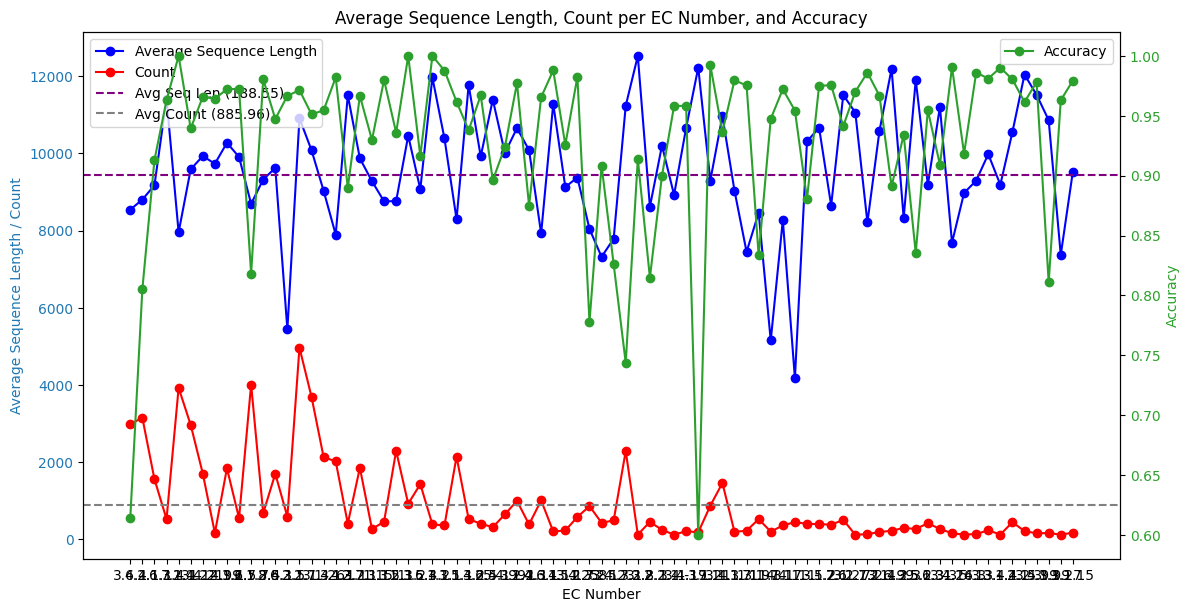

In [ ]:
class_accuracies = []
for i in range(num_classes):
    accuracy = class_correct[i] / class_total[i]
    class_accuracies.append((accuracy, i))

accuracies_only = [acc[0] for acc in class_accuracies]

total_length = Counter()
count = Counter()
for i in range(len(data)):
    ec = data.iloc[i]["ec_number_reduced"]
    sequence_length = len(data.iloc[i]["Sequence"])
    total_length[ec] += sequence_length
    count[ec] += 1

average_length = {ec: total_length[ec] / count[ec] for ec in count}

ec_numbers = list(count.keys())
average_lengths = [average_length[ec] * 50 for ec in ec_numbers]
counts = [count[ec] for ec in ec_numbers]
avg_count = sum(counts) / len(counts)

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('EC Number')
ax1.set_ylabel('Average Sequence Length / Count', color=color)
ax1.plot(ec_numbers, average_lengths, marker='o', color='blue', label='Average Sequence Length')
ax1.plot(ec_numbers, counts, marker='o', color='red', label='Count')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y=avg_seq_len * 50, color='purple', linestyle='--', label=f'Avg Seq Len ({avg_seq_len:.2f})')
ax1.axhline(y=avg_count, color='gray', linestyle='--', label=f'Avg Count ({avg_count:.2f})')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(ec_numbers, accuracies_only, marker='o', color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Average Sequence Length, Count per EC Number, and Accuracy')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


In [ ]:
all_counts = np.array([count for _, count in x])

outlier_percentiles = []
for ec_number, acc, train_occurrences, val_occurrences, total_occurrences in outlier_details:
    percentile = np.sum(all_counts < total_occurrences) / len(all_counts) * 100
    outlier_percentiles.append((ec_number, acc, train_occurrences, val_occurrences, total_occurrences, percentile))

for detail in outlier_percentiles:
    ec_number, acc, train_occurrences, val_occurrences, total_occurrences, percentile = detail
    print(f"EC Number: {ec_number}, Accuracy: {acc}, Train Occurrences: {train_occurrences}, "
          f"Validation Occurrences: {val_occurrences}, Total Occurrences: {total_occurrences}, "
          f"Percentile: {percentile:.2f}%")

EC Number: 1.-.-, Accuracy: 0.6140350877192983, Train Occurrences: 172, Validation Occurrences: 57, Total Occurrences: 229, Percentile: 29.11%
EC Number: 1.1.1, Accuracy: 0.8051948051948052, Train Occurrences: 280, Validation Occurrences: 77, Total Occurrences: 357, Percentile: 39.24%
EC Number: 1.5.1, Accuracy: 0.8181818181818182, Train Occurrences: 182, Validation Occurrences: 44, Total Occurrences: 226, Percentile: 27.85%
EC Number: 3.1.27, Accuracy: 0.7777777777777778, Train Occurrences: 89, Validation Occurrences: 27, Total Occurrences: 116, Percentile: 1.27%
EC Number: 3.2.1, Accuracy: 0.7435897435897436, Train Occurrences: 347, Validation Occurrences: 78, Total Occurrences: 425, Percentile: 50.63%
EC Number: 3.4.-, Accuracy: 0.8148148148148148, Train Occurrences: 90, Validation Occurrences: 27, Total Occurrences: 117, Percentile: 2.53%
EC Number: 3.4.24, Accuracy: 0.6, Train Occurrences: 134, Validation Occurrences: 20, Total Occurrences: 154, Percentile: 11.39%


In [ ]:
outlier_indices = [idx for acc, idx, ec_number in outliers]

outlier_fp_fn = {}

for outlier_index in outlier_indices:
    ec_number = index_to_ec[outlier_index]
    fp = class_false_positives[outlier_index]
    fn = class_false_negatives[outlier_index]
    outlier_fp_fn[ec_number] = {'FP': fp, 'FN': fn}

for ec_number, metrics in outlier_fp_fn.items():
    print(f"EC Number: {ec_number}, False Positives: {metrics['FP']}, False Negatives: {metrics['FN']}")


EC Number: 1.-.-, False Positives: 22, False Negatives: 22
EC Number: 1.1.1, False Positives: 24, False Negatives: 15
EC Number: 1.5.1, False Positives: 6, False Negatives: 8
EC Number: 3.1.27, False Positives: 8, False Negatives: 6
EC Number: 3.2.1, False Positives: 14, False Negatives: 20
EC Number: 3.4.-, False Positives: 3, False Negatives: 5
EC Number: 3.4.24, False Positives: 11, False Negatives: 8
EC Number: 7.2.1, False Positives: 1, False Negatives: 7


In [ ]:
from collections import defaultdict
import tqdm

# Initialize counters
correct = 0
total = 0
top_5_correct = 0
top_5_total = 0

class_correct = defaultdict(int)
class_false_positives = defaultdict(int)
class_false_negatives = defaultdict(int)
class_total = defaultdict(int)

with torch.no_grad():
    for batch in tqdm.tqdm(val_dataloader):
        inputs = torch.tensor(batch[0]["input_ids"]).to("cuda")
        attention_masks = torch.tensor(batch[0]["attention_mask"]).to("cuda")
        labels = batch[1].to("cuda")

        # Top-1 Accuracy
        logits, probs = model(inputs, attention_masks)
        pred_class = probs.argmax(-1).flatten()
        labels = labels.argmax(-1).flatten()
        correct += (pred_class == labels).sum().item()
        total += pred_class.shape[0]

        # Top-5 Accuracy
        pred_classes = probs.topk(5, dim=1)[1]

        for i in range(pred_classes.shape[0]):
            if labels[i] in pred_classes[i]:
                top_5_correct += 1
            top_5_total += 1

        # Accuracy per class
        for i in range(labels.shape[0]):
            if pred_class[i] == labels[i]:
                class_correct[labels[i].item()] += 1
            else:
                class_false_positives[pred_class[i].item()] += 1 # Prediction was wrong
                class_false_negatives[labels[i].item()] += 1 # Label was not predicted
            class_total[labels[i].item()] += 1

# Calculate precision, recall, and F1-score for each class
class_precision = {}
class_recall = {}
class_f1_score = {}
precision_count = 0
recall_count = 0


for cls in class_total.keys():
    tp = class_correct[cls]
    fp = class_false_positives[cls]
    fn = class_false_negatives[cls]

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    class_precision[cls] = precision
    class_recall[cls] = recall
    class_f1_score[cls] = f1_score

    precision_count += precision
    recall_count += recall

# Calculate macro and weighted F1-score
macro_f1 = sum(class_f1_score.values()) / len(class_f1_score)
weighted_f1 = sum(class_f1_score[cls] * class_total[cls] for cls in class_f1_score) / sum(class_total.values())

# Print overall accuracy
print(f'Overall Top-1 Accuracy: {correct / total:.4f}')
print(f'Overall Top-5 Accuracy: {top_5_correct / top_5_total:.4f}')

# Print precision, recall, and F1-score for each class
for cls in class_total.keys():
    print(f'Class {cls}: Precision = {class_precision[cls]:.4f}, Recall = {class_recall[cls]:.4f}, F1-score = {class_f1_score[cls]:.4f}')

# Print macro and weighted F1-scores
print(f'Macro F1-score: {macro_f1:.4f}')
print(f'Weighted F1-score: {weighted_f1:.4f}')
print(precision_count / len(class_total), recall_count / len(class_total))

100%|██████████| 219/219 [00:52<00:00,  4.19it/s]

Overall Top-1 Accuracy: 0.9458
Overall Top-5 Accuracy: 0.9803
Class 15: Precision = 0.9805, Recall = 0.9522, F1-score = 0.9662
Class 27: Precision = 0.9873, Recall = 0.9605, F1-score = 0.9738
Class 37: Precision = 0.9037, Recall = 0.9801, F1-score = 0.9403
Class 53: Precision = 0.9523, Recall = 0.9475, F1-score = 0.9499
Class 56: Precision = 0.9529, Recall = 0.8804, F1-score = 0.9153
Class 66: Precision = 0.9824, Recall = 0.9612, F1-score = 0.9717
Class 30: Precision = 0.8564, Recall = 0.8962, F1-score = 0.8758
Class 31: Precision = 0.9324, Recall = 0.9262, F1-score = 0.9293
Class 26: Precision = 0.9798, Recall = 0.9878, F1-score = 0.9838
Class 22: Precision = 0.9057, Recall = 0.9359, F1-score = 0.9205
Class 46: Precision = 0.9485, Recall = 0.9583, F1-score = 0.9534
Class 17: Precision = 1.0000, Recall = 0.9821, F1-score = 0.9910
Class 51: Precision = 0.8878, Recall = 0.9719, F1-score = 0.9280
Class 55: Precision = 0.9573, Recall = 0.9544, F1-score = 0.9559
Class 45: Precision = 0.9857

In [ ]:
for i in class_accuracies:
    print(i[0], index_to_ec[i[1]])

0.6140350877192983 1.-.-
0.8051948051948052 1.1.1
0.9130434782608695 1.11.1
0.9629629629629629 1.13.11
1.0 1.14.11
0.9393939393939394 1.14.99
0.9659090909090909 1.15.1
0.9642857142857143 1.16.3
0.9722222222222222 1.17.1
0.9726027397260274 1.4.3
0.8181818181818182 1.5.1
0.9805825242718447 1.6.5
0.9473684210526315 1.7.1
0.9666666666666667 1.8.4
0.9714285714285714 1.97.1
0.9512437810945273 2.1.1
0.9545454545454546 2.1.3
0.9821428571428571 2.2.1
0.8897435897435897 2.3.1
0.9666666666666667 2.3.2
0.9298245614035088 2.4.1
0.98 2.4.2
0.935933147632312 2.5.1
1.0 2.6.99
0.9164265129682997 2.7.1
1.0 2.7.11
0.9878048780487805 2.7.4
0.9617755856966708 2.7.7
0.937888198757764 2.7.8
0.967032967032967 2.8.1
0.8961748633879781 3.1.-
0.9239373601789709 3.1.1
0.9772727272727273 3.1.11
0.875 3.1.13
0.9655172413793104 3.1.15
0.9879518072289156 3.1.2
0.9257142857142857 3.1.21
0.9825870646766169 3.1.26
0.7777777777777778 3.1.27
0.9084745762711864 3.1.3
0.8260869565217391 3.1.4
0.7435897435897436 3.2.1
0.9137